# 07 - DecisionTree

Realizando a predição com DecisionTree. Lembrando que a acurácia para os dados de treino precisa ser superior a 78% para que seja considerada válida para testarmos com os dados de teste.

A escolha do algoritmo é pela facilidade de interpretação do mesmo e não pela capacidade de acurácia. Os tratamentos foram utilizados os mesmos de antes. Não quer dizer que são os melhores possíveis.

## Preparando o ambiente

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler
import graphviz
from IPython.display import display

In [3]:
sns.set_theme(rc={'figure.figsize':(18, 12)})

In [30]:
SEED = 42
np.random.seed(SEED)

Código abaixo para exibir a árvore gerada pelo algoritmo.

In [4]:
def exibir_arvore(modelo):
  dot_data = export_graphviz(modelo, 
                  out_file=None,
                  filled=True,
                  rounded=True)
  display(graphviz.Source(dot_data))

## Carregando os dados

### Carregando dados de treino

In [61]:
titanic = pd.read_csv('../data/processed/train_processed_byage_ag.csv')
del titanic['Unnamed: 0']
titanic.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Relateds,cod_faixa_etaria,faixa_etaria,acompanhado,possui_cabine
0,0,3,male,22,1,0,SC,1,1,crianca_adolescente,True,False
1,1,1,female,38,1,0,C,1,1,crianca_adolescente,True,True
2,1,3,female,26,0,0,SC,0,1,crianca_adolescente,False,False
3,1,1,female,35,1,0,C,1,1,crianca_adolescente,True,True
4,0,3,male,35,0,0,SC,0,1,crianca_adolescente,False,False


### Transformando dados categóricos

In [62]:
sex_map = {
    'male': 0,
    'female': 1
}
titanic['Sex'] = titanic['Sex'].map(sex_map)
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Relateds,cod_faixa_etaria,faixa_etaria,acompanhado,possui_cabine
0,0,3,0,22,1,0,SC,1,1,crianca_adolescente,True,False
1,1,1,1,38,1,0,C,1,1,crianca_adolescente,True,True


In [63]:
boolean_map = {
    True: 1,
    False: 0
}
titanic['acompanhado'] = titanic['acompanhado'].map(boolean_map)
titanic['possui_cabine'] = titanic['possui_cabine'].map(boolean_map)
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Relateds,cod_faixa_etaria,faixa_etaria,acompanhado,possui_cabine
0,0,3,0,22,1,0,SC,1,1,crianca_adolescente,1,0
1,1,1,1,38,1,0,C,1,1,crianca_adolescente,1,1


In [64]:
titanic['Floor'].unique()

array(['SC', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [65]:
floor_map = {
    'SC': 0,
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 8
}
titanic['Floor'] = titanic['Floor'].map(floor_map)
titanic.isnull().sum()

Survived            0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Floor               0
Relateds            0
cod_faixa_etaria    0
faixa_etaria        0
acompanhado         0
possui_cabine       0
dtype: int64

In [66]:
faixa_etaria_map = {
    'jovem_adulto': 1,
    'adulto_idoso': 2,
    'crianca_adolescente': 0
}
titanic['faixa_etaria'] = titanic['faixa_etaria'].map(faixa_etaria_map)

In [68]:
titanic.drop(columns=['cod_faixa_etaria'], inplace=True)
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Relateds,faixa_etaria,acompanhado,possui_cabine
0,0,3,0,22,1,0,0,1,0,1,0
1,1,1,1,38,1,0,3,1,0,1,1


### Carregando dados de teste

In [70]:
teste = pd.read_csv('../data/processed/test_processed.csv')
del teste['Unnamed: 0']

teste['acompanhado'] = teste['acompanhado'].map(boolean_map)
teste['possui_cabine'] = teste['possui_cabine'].map(boolean_map)
teste['Floor'] = teste['Floor'].map(floor_map)
teste['Sex'] = teste['Sex'].map(sex_map)
teste['faixa_etaria'] = teste['faixa_etaria'].map(faixa_etaria_map)

# Mantendo as colunas na mesma ordem
columns = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Floor', 'Relateds', 'faixa_etaria', 'acompanhado', 'possui_cabine']
teste.columns = columns

# Chamando os dados de testes originais de validação - nome mais correto para esse contexto
Xvalidacao = teste.drop(columns=['PassengerId'])
Xvalidacao.head(5)

,Pclass,Sex,Age,SibSp,Parch,Floor,Relateds,faixa_etaria,acompanhado,possui_cabine
0,3,0,34,0,0,0,0,0,0,1
1,3,1,47,1,0,0,1,0,1,2
2,2,0,62,0,0,0,0,0,0,2
3,3,0,27,0,0,0,0,0,0,1
4,3,1,22,1,1,0,2,0,1,1


### Separando treino e teste

In [71]:
X = titanic.drop(columns=['Survived'])
y = titanic['Survived']

treino_x, teste_x, treino_y, teste_y = train_test_split(X, y, test_size = 0.2, stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 712 elementos e testaremos com 179 elementos


## Execução da Árvore de decisão

A execução abaixo testa vários parâmetros para a árvore de decisão.

In [72]:
def dt_grid_search(treino_x, treino_y, teste_x, teste_y):
    criterion = ["gini", "entropy"]
    max_depth = [2, 3, 5, 7, 9, 11, 13]
    min_samples_split = [2, 8, 16, 32]
    min_samples_leaf = [1, 2, 8, 16, 32]
    resultados = []

    for c in criterion:
        for md in max_depth:
            for ms in min_samples_split:
                for ml in min_samples_leaf:
                    modelo = DecisionTreeClassifier(criterion = c, max_depth = md, min_samples_split = ms, min_samples_leaf = ml)
                    modelo.fit(treino_x, treino_y)
                    score = modelo.score(teste_x, teste_y)
                    resultados.append({
                        "criterion": c,
                        "max_depth" : md,
                        "min_samples_split": ms,
                        "min_samples_leaf": ml,
                        "score": score
                    })

    return pd.DataFrame(resultados)
    
resultados = dt_grid_search(treino_x, treino_y, teste_x, teste_y).sort_values(by='score', ascending=False)
resultados

,criterion,max_depth,min_samples_split,min_samples_leaf,score
52,gini,5,16,8,0.854749
47,gini,5,8,8,0.854749
42,gini,5,2,8,0.854749
32,gini,3,16,8,0.854749
22,gini,3,2,8,0.854749
...,...,...,...,...,...
136,gini,13,32,2,0.804469
137,gini,13,32,8,0.804469
1,gini,2,2,2,0.804469
0,gini,2,2,1,0.804469


In [90]:
best_params = {
    'criterion': 'gini',
    'max_depth': 5,
    'min_samples_split': 16,
    'min_samples_leaf': 8
}

In [91]:
melhor_modelo = DecisionTreeClassifier().set_params(**best_params)
melhor_modelo.fit(treino_x, treino_y)
predicoes_teste = melhor_modelo.predict(teste_x)
accuracy_score(teste_y, predicoes_teste)

0.8547486033519553

Score em teste já parece superior ao que foi antes com a Classificação Manual (79%). Como será que se comporta com o Kaggle?

## Validando com dados de teste do Kaggle

Antes de enviar para o Kaggle, vamos treinar agora com a totalidade dos dados de treino.

In [92]:
predicoes = melhor_modelo.predict(Xvalidacao)
resultado = pd.DataFrame()
resultado['PassengerId'] = teste['PassengerId']
resultado['Survived'] = predicoes
resultado.sample(5)

,PassengerId,Survived
296,1188,1
33,925,0
349,1241,1
259,1151,0
323,1215,0


In [93]:
resultado.to_csv('../data/submissions/3_decision_tree.csv', index=False)

In [94]:
ground_truth = pd.read_csv('../data/original/ground_truth.csv')
merged = pd.merge(ground_truth, resultado, on='PassengerId', how='inner', suffixes=('_expected', '_predicted'))
acuracia = round(merged[merged['Survived_expected'] == merged['Survived_predicted']].shape[0] / merged.shape[0] * 100, 2)
print(f'Acurácia de {acuracia}% nos dados de teste (submissão Kaggle)')

Acurácia de 77.27% nos dados de teste (submissão Kaggle)


A acurácia no Kaggle foi de **77.3%**, ou seja, pouco melhor que o classificador manual (75.4%).

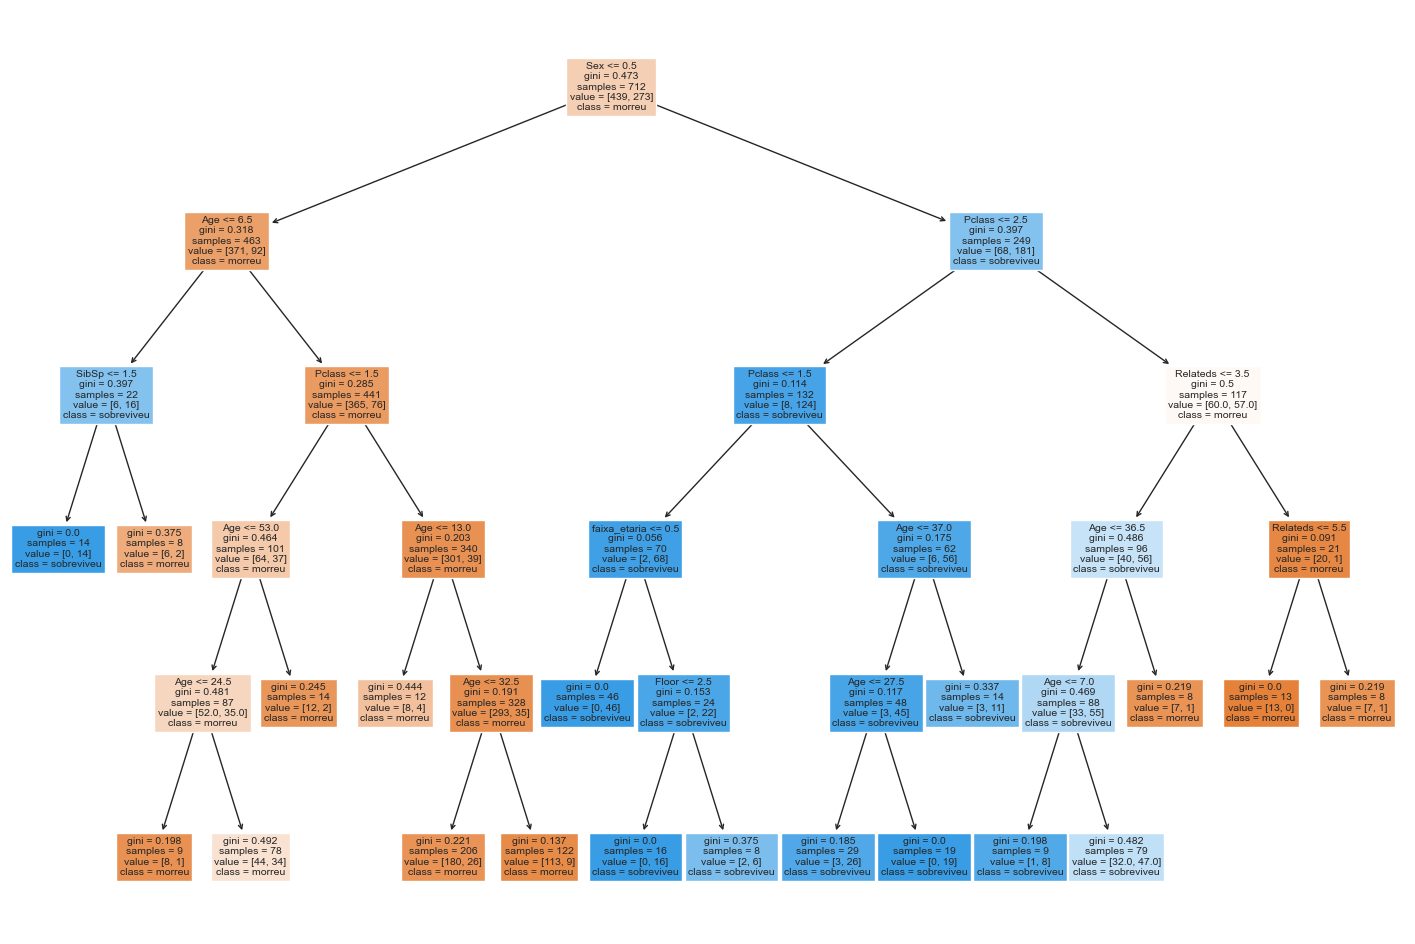

In [103]:
from sklearn import tree
tree.plot_tree(melhor_modelo, feature_names=X.columns, class_names=['morreu', 'sobreviveu'], filled=True);